## Setups

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage
import mne
from scipy.signal import welch

import torch
import keras
from sklearn.manifold import TSNE
import json
from src.EEGModalNet.data.dataloader import LEMONEEGDataModule
from src.EEGModalNet.models.gan import SimpleGAN
from src.EEGModalNet.data.mock_temporal_data import MockTemporalData
from src.EEGModalNet.utils import ProgressBarCallback
from src.EEGModalNet.models.WGAN import WGAN_GP
from tqdm.auto import tqdm


# helper functions
def train_model(model, x, max_epochs, early_stopping=True, logger_dir='tmp/keras_logs/simple_gan_v1.csv', patience=100):
    reusable_pbar=tqdm(total=max_epochs, unit='epoch', leave=False, dynamic_ncols=True)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                d_optimizer=keras.optimizers.Adam(0.001),
                g_optimizer=keras.optimizers.Adam(0.0001))
    
    callbacks = [keras.callbacks.CSVLogger(logger_dir),
                 ProgressBarCallback(n_epochs=max_epochs, n_runs=1, run_index=0, reusable_pbar=reusable_pbar)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='d_loss', mode='min', patience=patience))

    history = model.fit(
        x,
        epochs=max_epochs,
        verbose=0, # type: ignore
        shuffle=True,
        callbacks=callbacks
    )
    return history

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['d_loss'], label='discriminator')
    plt.plot(history.history['g_loss'], label='generator')
    plt.legend()
    plt.show()

def plot_step_losses(step_loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(step_loss_history.step_losses['d_loss'], label='discriminator')
    plt.plot(step_loss_history.step_losses['g_loss'], label='generator')
    plt.legend()
    plt.show()

sns.color_palette("viridis", as_cmap=True)
sns.set_style('darkgrid')

# Plotting helper functions
def plot_onebyone(x_gen, x, n_seg=5, ch=0, time_dim=512):
    for i in range(n_seg):
        plt.figure(figsize=(2*n_seg, n_seg//2))
        plt.plot(x_gen[i, :time_dim, ch], label='generated')
        plt.plot(x[i, :time_dim, ch], label='real')
        plt.xlim(0, time_dim)
        plt.legend()
        plt.show()

def plot_overlap(x, n_seg=5, ch=0, time_dim=512, start_from=0):
    plt.figure(figsize=(20, 2))
    for i in range(start_from, start_from+n_seg):
        plt.plot(x[i, :time_dim, ch])
    plt.xlim(0, time_dim)
    plt.show()

def plot_psd(x, fmin=1, fmax=60, n_fft=512, label='real', show=True):
    psd, freq = mne.time_frequency.psd_array_welch(x.flatten(0, 1).permute(1, 0).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    plt.plot(freq, 10*np.log10(psd.mean(0)), label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def compare_psds(x, x_gen, lim=[20, 100], nperseg=2048, nfft=2048):
    f, Pxx = welch(x, fs=128, nperseg=nperseg, nfft=nfft)
    f_gen, Pxx_gen = welch(x_gen, fs=128, nperseg=nperseg, nfft=nfft)
    plt.plot(f[lim[0]:lim[1]], Pxx[lim[0]:lim[1]], label='real')
    plt.plot(f_gen[lim[0]:lim[1]], Pxx_gen[lim[0]:lim[1]], label='generated')
    plt.legend()
    plt.show()

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

def plot_tsne(x, x_gen):
    sample_len = x.shape[0]
    x_flat = x.mean(axis=2)
    x_flat_hat = x_gen.mean(axis=2)
      
    x_flat_final = np.concatenate((x_flat, x_flat_hat), axis = 0)
    tsne = TSNE(n_components=2, verbose=1, perplexity=20)
    tsne_results = tsne.fit_transform(x_flat_final)
        
    # Plotting
    f, ax = plt.subplots(1)
    colors = ["red" for i in range(sample_len)] + ["blue" for i in range(sample_len)]
        
    plt.scatter(tsne_results[:sample_len, 0], tsne_results[:sample_len,1], 
                c = colors[:sample_len], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[sample_len:, 0], tsne_results[sample_len:, 1], 
                c = colors[sample_len:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

def plot_psd4sujects(x, channels):
    """ Plot the power spectral density for different channels for each subjects """
    psd, freq = mne.time_frequency.psd_array_welch(x, sfreq=128, n_fft=128, fmax=60)
    for j in range(x.shape[0]):
        plt.figure(figsize=(10, 5))
        for i in range(x.shape[1]):
            plt.plot(freq, 10*np.log10(psd[j, i, :]))
        # stick the channel name to the corresponding line
        for i in range(61):
            plt.text(60, 10*np.log10(psd[j, i, -1]), channels[i], fontsize=8)
        plt.title(f'Subject {j}')
        plt.show()

def plot_raw4subject_channel(xarray, sub=0, chann_list=['O1'], start=0, filter=True, filter_range=[1, 60]):
    if isinstance(sub, int):
        x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    else:
        x = xarray.sel(subject=sub).to_numpy()
    idx = find_channel_ids(xarray, chann_list)
    x = x[idx, :]
    if filter:
        x = mne.filter.filter_data(x, 128, filter_range[0], filter_range[1], method='fir', verbose=False)  # filter data
    x = torch.tensor(x).unsqueeze(0)
    x = x.unfold(2, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
    plot_overlap(x, start_from=start)

def save_step_losses(step_losses, filename='step_losses.json'):
    with open(filename, 'w') as f:
        json.dump(step_losses, f)

# Custom Callbacks
# callback to log losses at each step
class StepLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.step_losses = {'g_loss': [], 'd_loss': []}

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.step_losses['g_loss'].append(logs.get('g_loss'))
        self.step_losses['d_loss'].append(logs.get('d_loss'))

## DATA

In [2]:
# 1. DATA
import numpy as np
from pathlib import Path
data_path = 'data/LEMON_data/EEG_Preprocessed/'

channel = 'F1'
processed = False
filtering = False
time_dim = 1024
n_subject = 20

if processed:
    data_ec = {}

    # read epochs data with mne
    for i in Path(data_path).glob('sub-01000*_EC.set'):
        sub_id = i.stem
        raw_ec = mne.io.read_raw_eeglab(i, verbose=False)
        if channel in raw_ec.ch_names:
            raw_ec = raw_ec.pick([channel]).get_data()
            data_ec[sub_id] = raw_ec

    data = {k: torch.tensor(v).unfold(1, time_dim, time_dim).permute(1, 2, 0) for k, v in data_ec.items()}
    del data_ec

    # create sub_ids
    sub_ids = np.array([]).astype(int)
    for i, k in enumerate(data.keys()):
        sub_ids = np.concatenate((sub_ids, np.array([int(i)]*data[k].shape[0], dtype=int)), dtype=int)

    sub_ids = sub_ids[:, np.newaxis]

    # sanity check
    print(np.unique(sub_ids, return_counts=True))

    x = np.zeros([1, time_dim, 1])
    for k in data.keys():
        x = np.concatenate((x, data[k]), axis=0)
    x = x[1:]
    data = {'x': x, 'sub': sub_ids}

else:
    # data
    data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
    xarray = xr.open_dataarray(data_path, engine='h5netcdf')

    x = xarray.sel(subject=xarray.subject[:n_subject]).to_numpy()
    # ch_list = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'Fz', 'Cz', 'Pz', 'Oz', 'F7', 'F8']
    ch_list = [channel]
    ch_ids = find_channel_ids(xarray, ch_list)
    x = x[:, ch_ids, 440:]
    if filtering:
        x = mne.filter.filter_data(x, 128, 1, None, method='fir', verbose=False)  # filter data
    x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
    sub = np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis]
    data = {'x': x, 'sub': sub}

## TRAINING

In [45]:
from keras import layers
critic = keras.Sequential([
            keras.Input(shape=(512, 1)),
            layers.Conv1D(1, 3, padding='same', activation='relu', name='conv1'),
            layers.Flatten(name='dis_flatten'),
            layers.Dense(512, activation='relu', name='dis_dense1'),
            layers.Dense(128, activation='relu', name='dis_dense2'),
            layers.Dense(64, activation='relu', name='dis_dense3'),
            layers.Dense(1, name='dis_dense4')
        ], name='critic')
critic.summary()

Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv1D)                  │ (None, 512, 1)         │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_flatten (Flatten)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_dense1 (Dense)              │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_dense2 (Dense)              │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_dense3 (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_dense4 (Dense)              │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,645 (1.28 MB)

 Trainable params: 336,645 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

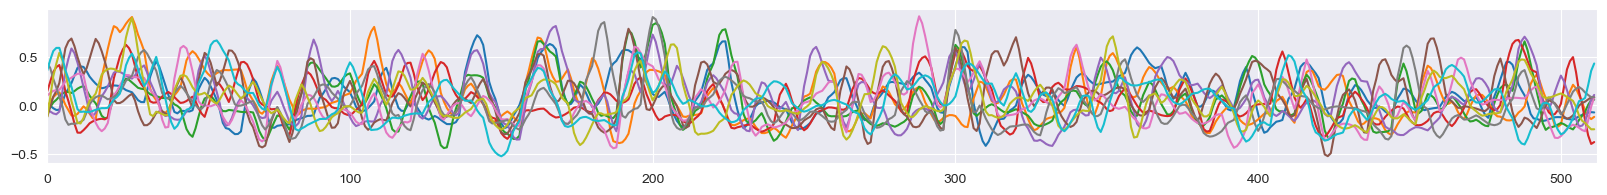

In [8]:
# 2. MODEL and Plot generated data by the model before training
latent_dim = 64
wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=1, latent_dim=latent_dim, n_subjects=n_subject, use_sublayers=False)
x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std())).cpu().detach()
plot_overlap(x_gen, n_seg=10, start_from=20)
# wgan_gp.generator.summary()

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


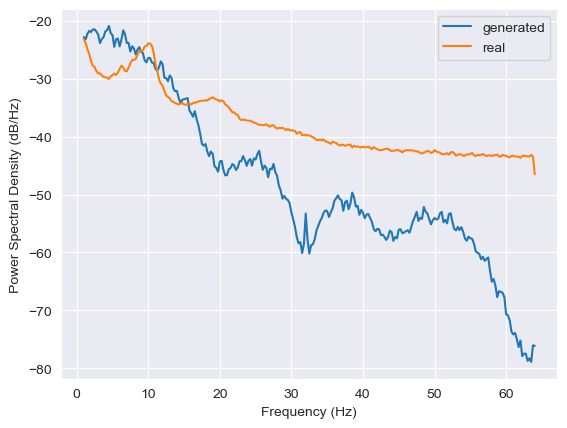

In [9]:
plot_psd(x_gen, fmin=1, fmax=200, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, fmax=200, n_fft=512, label='real', show=True)
plt.show()

In [28]:
step_loss_history = StepLossHistory()

# 3. TRAINING
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.001, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=1.0)
# training
history = wgan_gp.fit(data, epochs=20, batch_size=64, callbacks=[step_loss_history])

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - d_loss: -0.4081 - g_loss: -1.4740
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - d_loss: -1.0278 - g_loss: -2.0376
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - d_loss: -0.6427 - g_loss: -4.2286
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - d_loss: -0.7874 - g_loss: -1.6605
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - d_loss: -0.9261 - g_loss: -1.5377
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - d_loss: -0.7878 - g_loss: 1.0797
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - d_loss: -0.7472 - g_loss: 2.5408
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - d_loss: -0.2426 - g_loss: 3.6050
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - d_loss: -0.6975 - g_loss: 3.1241
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - d_loss: -0.9118 - g_loss: 0.2833
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - d_loss: -1.1686 - g_loss: 3.3666
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━

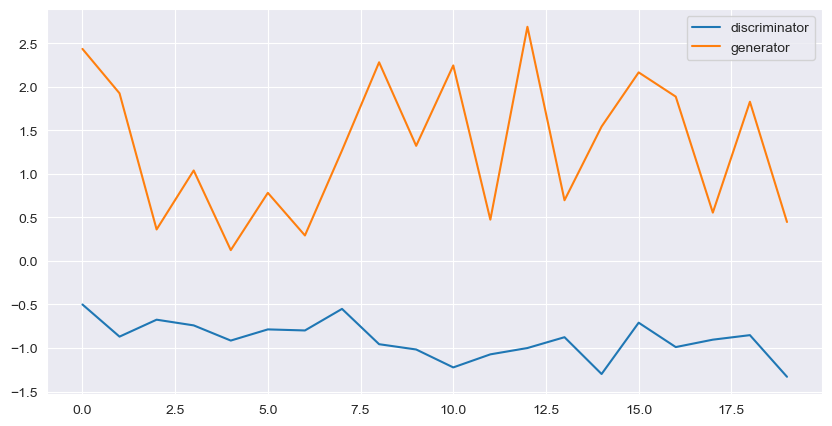

In [29]:
plot_history(history)

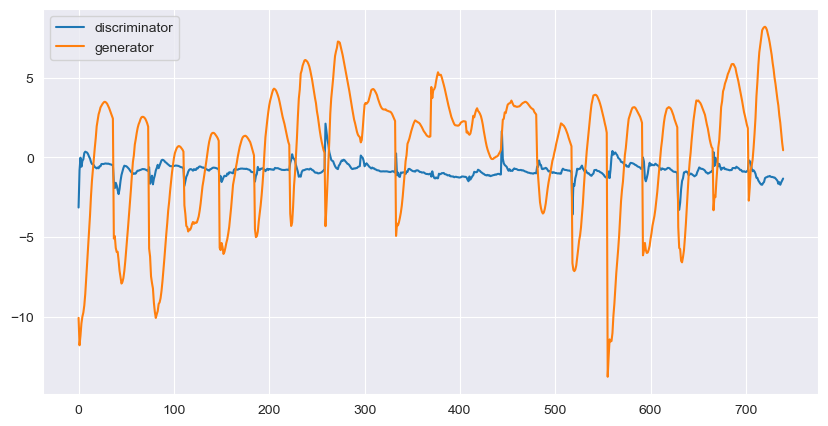

In [30]:
plot_step_losses(step_loss_history)
# save_step_losses(step_loss_history.step_losses, filename='tmp/keras_losses/step_losses.json')

## Evaluations & Visualisations

In [31]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
sigmoid(wgan_gp.critic(x_gen).mean().item()), sigmoid(wgan_gp.critic(x).mean().item())

(0.9999987881423451, 0.9999996296249032)

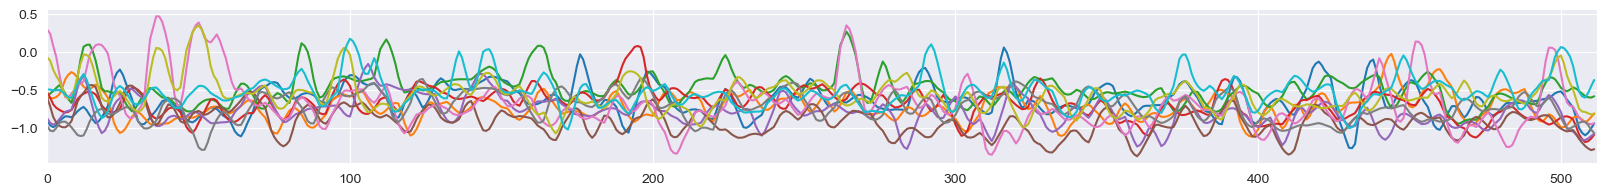

In [32]:
x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std())).cpu().detach()
plot_overlap(x_gen, n_seg=10, start_from=20)

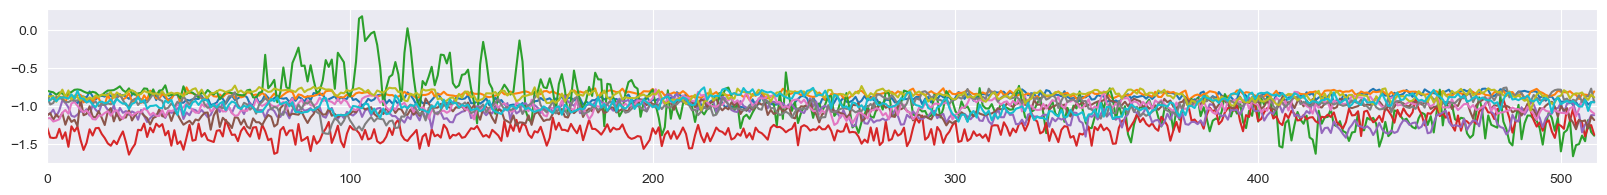

In [26]:
plot_overlap(x, n_seg=10, start_from=20)

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


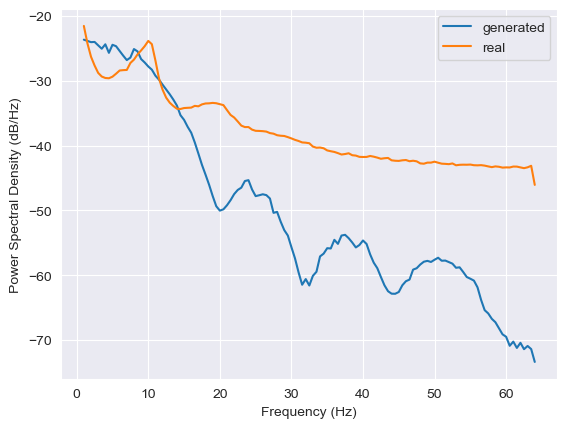

In [33]:
plot_psd(x_gen, fmin=1, fmax=200, n_fft=256, label='generated', show=False)
plot_psd(x, fmin=1, fmax=200, n_fft=256, label='real', show=True)
plt.show()